# Load MR images in Colab

Start by loading your 3T and 7T MR images in your Colab environment.

In [ ]:
# importing libraries 
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mixed precision policy

In order to make our models faster, we will use [TensorFlow mixed-precision](https://www.tensorflow.org/guide/mixed_precision).

In [ ]:
from tensorflow.keras import mixed_precision
import tensorflow as tf
mixed_precision.set_global_policy('mixed_float16')

# Data pipepline

In deep learning, the models consume a lot of data and the efficiency of the input pipeline is a key aspect to reduce the training time. TensorFlow gives [a lot of ideas](https://www.tensorflow.org/guide/data) for optimizing pipelines. We will here implement some of them by using the [Dataset class](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

## Python generator

The Dataset class provides the `from_generator` function that enables to instantiate a Tensorflow dataset from a Python generator.

Define a function that takes subject identifiers (or filenames) and that returns an iterator object that iterates through the corresponding pairs of 3T/7T MR images (tuple of 2 float32 tensors). You can use the `yield` keyword, as it is done [here](https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/).

In [ ]:
# new generator 
f_3T_name = '/content/drive/MyDrive/G4/MLSP/project/final_data/3T_images'
f_7T_name = '/content/drive/MyDrive/G4/MLSP/project/final_data/7T_images'

list_3T = [name for name in os.listdir(f_3T_name)]
list_7T = [name for name in os.listdir(f_7T_name)]

def generator(exclude=-1):
  for i, filename in enumerate(list_3T):
    if i != exclude:
      img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
      img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()

      # convert to tensors
      img_3T = tf.convert_to_tensor(img_3T, dtype=tf.float32)
      img_7T = tf.convert_to_tensor(img_7T, dtype=tf.float32)
      yield img_3T, img_7T

generator()

<generator object generator at 0x7fa9fa387dd0>

## Patch extraction

As in the reference paper, the models will be trained on 64x64x3 patches (3 axial slices).

Define a function that takes 2 MR images as arguments (i.e. 3T and 7T MR images) and that returns 2 64x64x3 patches extracted from the 1st and 2nd images, respectively. The position of the patches in the 3D volumes is randomly drawn (same position for the 2 images). To avoid background slices, prevent the sampling of the 30 axial slices on each side (i.e. 60 slices excluded). Set the number of excluded slices in a variable which will be reused later.

Note that this function will be used later as a TensorFlow function. This means that the arguments are tensors and that the body must only contain TensorFlow operations or native Python (i.e. no imported modules).

In [ ]:
def patch_extraction(tf_3T, tf_7T, nb_exc_slices=30):
  idx = tf.random.uniform(shape=(2,), dtype=tf.int32, maxval=3000000)
  return tf.image.stateless_random_crop(tf_3T[:, :, nb_exc_slices: -nb_exc_slices], [64, 64, 3], seed=idx), tf.image.stateless_random_crop(tf_7T[:, :, nb_exc_slices: -nb_exc_slices], [64, 64, 3], seed=idx)

## TensorFlow dataset

Define a function that will instantiate a training TensorFlow dataset from subject identifiers by following this procedure:
  1. **data reading** with `Dataset.from_generator`.
  2. **patch sampling** with `Dataset.map`.
  3. **batching** of the training pairs with `Dataset.batch`. We will use a batch size of 32 as in the reference paper.

After the step 1, insert a call to `Dataset.cache` to avoid the costly data reading at the beginning of each epoch. Add a `Dataset.shuffle` to randomize the subject sampling. Using `Dataset.repeat`, make each epoch iterate 40 times over the training set.

After the step 3, add a call to `Dataset.prefetch` to further accelerate the pipeline.

Check the arguments of the functions you use in order to further optimize the procedure (e.g. *num_parallel_calls* of `Dataset.map`).

In [ ]:
def training_dataset(exclude=-1):
  dataset = tf.data.Dataset.from_generator(generator, args=(exclude,), output_signature=(
      tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32), 
      tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32)
    ))
  dataset = dataset.cache()
  if exclude == -1:
    dataset = dataset.shuffle(10)
  else:
    dataset = dataset.shuffle(9)
  dataset = dataset.repeat(40)
  dataset = dataset.map(patch_extraction, tf.data.AUTOTUNE)
  dataset = dataset.batch(32)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset


In [ ]:
dataset = training_dataset()
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None))>

# Model architecture

In this section, a CNN architecture for the 3T-to-7T translation is described. It is a sequential architecture that is much simpler than the one of the reference paper.

The architecture is the following:
  1. *conv(64)*
  2. *conv(128)*
  3. *conv(256)*
  4. *conv(3)*

*conv(C)* is a convolution with *C* output channels, kernel sizel $4^2$, strides $1^2$. A padding is done to make the output channels having the same dimension as the input ones. Except the last one, each convolution is followed by a batch normalization and a ReLU activation. The last convolution is followed by a sigmoid activation, which should be casted to float32 to stabilize the mixed precision computations (i.e. `tf.keras.layers.Activation('sigmoid', dtype='float32')`.

[This guide](https://www.tensorflow.org/guide/keras/sequential_model) may be useful for the implementation of a sequential model.

Note: I recommend a smaller *momentum* parameter for the batch normalizations than the default ones (e.g. 0.9).

Define a function (or a class) that instantiates a model with such an architecture.

In [ ]:
def final_model():
  inputs = keras.Input(shape=(None, None, 3))
  x = layers.Conv2D(filters=64, kernel_size=4, strides=(1,1), padding='same')(inputs)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Activation('ReLU', dtype='float32')(x)

  x = layers.Conv2D(filters=128, kernel_size=4, strides=(1,1), padding='same')(x)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Activation('ReLU', dtype='float32')(x)

  x = layers.Conv2D(filters=256, kernel_size=4, strides=(1,1), padding='same')(x)
  x = layers.BatchNormalization(momentum=0.9)(x)
  x = layers.Activation('ReLU', dtype='float32')(x)
   
  x = layers.Conv2D(filters=3, kernel_size=4, strides=(1,1), padding='same')(x)
  outputs = layers.Activation('sigmoid', dtype='float32')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model


In [ ]:
model = final_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    3136      
                                                                 
 batch_normalization_3 (Batc  (None, None, None, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, None, None, 64)    0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 128)   131200    
                                                                 
 batch_normalization_4 (Batc  (None, None, None, 128)  512       
 hNormalization)                                             

Instantiate a model and visualize a reprensation with the `tf.keras.Model.summary` function. You should have 672 963 parameters.

# Inference function

We will follow the method of the reference paper for inference. It uses the flexibility of the CNNs to apply them on entire axial slices (not 64x64 patches as for training). 3 axial slices are processed at a time (as for training) and overlapped slices in the output volume are averaged. As we excluded axial slices on the sides of the volumes for training, we will also exclude them at inference and let them unchanged against the 3T MR image.

Define a function that takes an MR image and a model and that returns the inferred 3T-to-CT volume.

In [ ]:
def inference(tf_3T, model, nb_exc_slices=30):
  outputs = [tf_3T[:, :, :nb_exc_slices]]

  for i in range(nb_exc_slices, (tf_3T.shape[2]-nb_exc_slices)//3*3, 3):
    outputs.append(model(tf.expand_dims(tf_3T[:, :, i:i+3], axis=0))[0])
  
  slice_to_avg = 3 - (tf_3T.shape[2]-nb_exc_slices) % 3
  # add last 3 slices
  b_last = outputs.pop()
  last = model(tf.expand_dims(tf_3T[:, :, -nb_exc_slices-3:-nb_exc_slices], axis=0))[0]
  avg_slice = tf.keras.layers.Average()([b_last[:, :, -slice_to_avg:], last[:, :, :slice_to_avg]])  # avgeraged slices

  outputs.append(b_last[:, :, :-slice_to_avg])
  outputs.append(tf.cast(avg_slice, dtype='float32'))
  outputs.append(last[:, :, -(3-slice_to_avg):])
  outputs.append(tf_3T[:, :, -nb_exc_slices:])

  return tf.concat(outputs, axis=2)

In [ ]:
xx = tf.constant([1, 2, 3, 4, 5, 6])
xx.shape

TensorShape([6])

# Training and evaluation

As in the reference paper, we will perform a leave-one-out cross validation for evalutation. We will not use validation sets as we only have 10 subjects.

## Display function

Define a function that takes an MR image (numpy array) and that shows one slice in each dimension (1 line, 3 columns).

In [ ]:
def display_slice_per_dimension(mr_img, slice_x=100, slice_y=100, slice_z=100):
  fig, ax = plt.subplots(1, 3, figsize=(3*5, 5))
  ax[0].imshow(mr_img[slice_x, :, :], cmap='gray')
  ax[1].imshow(mr_img[:, slice_y, :], cmap='gray')
  ax[2].imshow(mr_img[:, :, slice_z], cmap='gray')

  ax[0].set(title='slice along x')
  ax[1].set(title='slice along y')
  ax[2].set(title='slice along z')

  plt.show()
  

(182, 218, 182)


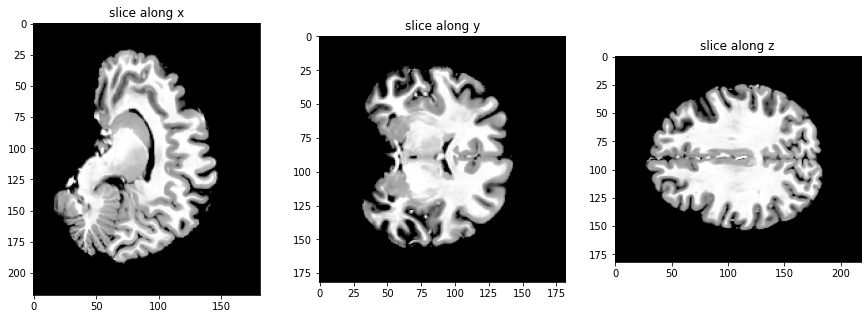

In [ ]:

xx = nib.load(os.path.join(f_7T_name, list_7T[5])).get_fdata()
print(xx.shape)
display_slice_per_dimension(xx)

## Training configuration

We will now set some training parameters:
  - number of epochs
  - optimizer $\rightarrow$ you can create a function that instantiates an optimizer for each training. You can use an [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with a linear learning rate decay from 0.001 to 0.0001 ([this class](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay) may be useful).
  - traing loss $\rightarrow$ MAE as in the reference paper. 

In [ ]:
EPOCHS = 30
START_LR_RATE = 0.001
END_LR_RATE = 0.0001
DECAY_STEPS = 10
POWER = 1.   # linear learning rate decay

optim_schedules = tf.keras.optimizers.schedules.PolynomialDecay(
    START_LR_RATE,
    DECAY_STEPS,
    END_LR_RATE,
    power=POWER)

model = final_model()
optimizer = tf.keras.optimizers.Adam(
                  learning_rate=optim_schedules)

model.compile(optimizer=optimizer,
              loss='mae', 
              run_eagerly=True)


## Execution

Execute the leave-one-out cross validation. After each of the 10 trainings, give some results:
  1. plot the evolution of the training loss
  2. show the test images (3T and 7T) and the inferred 7T image
  3. print the MAE before and after 3T-to-7T translation

At the end of the 10 trainings, print the MAE over the 10 subjects before and after 3T-to-7T translation.

Epoch 1/10
12/12 [==============================] - 14s 317ms/step - loss: 0.1182
Epoch 2/10
12/12 [==============================] - 3s 221ms/step - loss: 0.0559
Epoch 3/10
12/12 [==============================] - 3s 223ms/step - loss: 0.0541
Epoch 4/10
12/12 [==============================] - 3s 196ms/step - loss: 0.0466
Epoch 5/10
12/12 [==============================] - 3s 218ms/step - loss: 0.0457
Epoch 6/10
12/12 [==============================] - 3s 219ms/step - loss: 0.0437
Epoch 7/10
12/12 [==============================] - 3s 200ms/step - loss: 0.0402
Epoch 8/10
12/12 [==============================] - 3s 221ms/step - loss: 0.0425
Epoch 9/10
12/12 [==============================] - 3s 222ms/step - loss: 0.0401
Epoch 10/10
12/12 [==============================] - 3s 207ms/step - loss: 0.0375
SSIM: 0.9610000252723694 | PNSR: 29.268999099731445 | MAE: 0.010999999940395355
Epoch 1/10
12/12 [==============================] - 4s 218ms/step - loss: 0.1078
Epoch 2/10
12/12 [=========

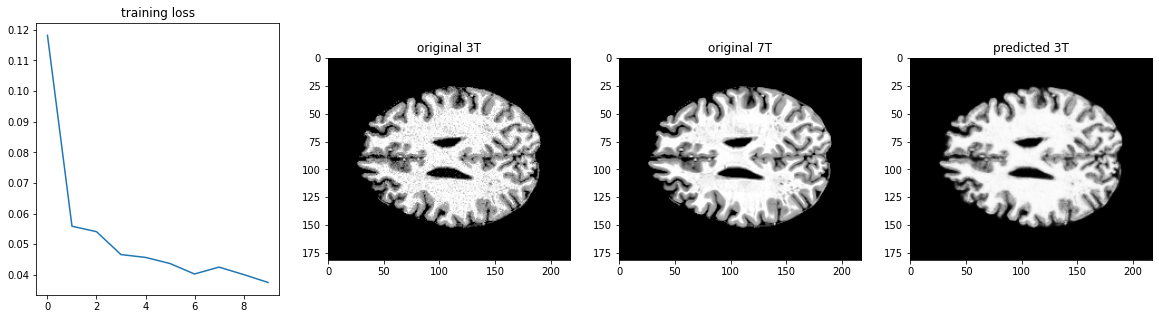

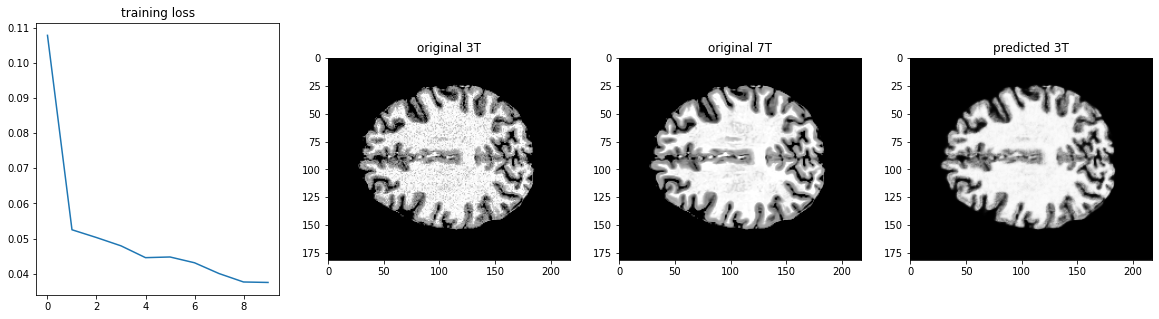

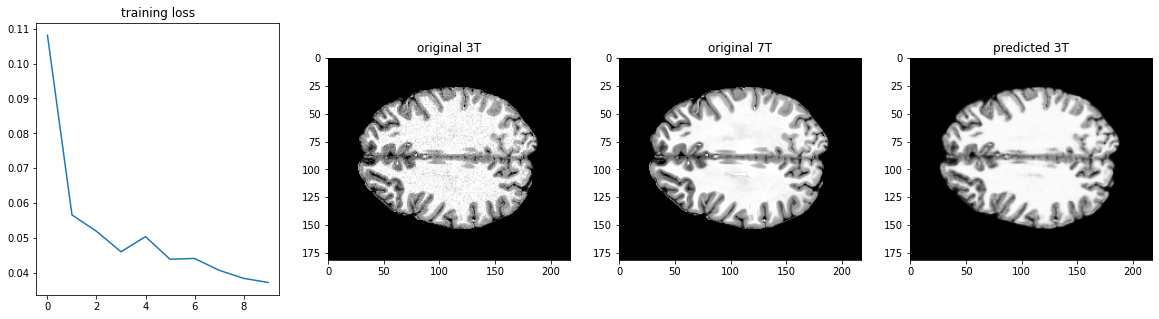

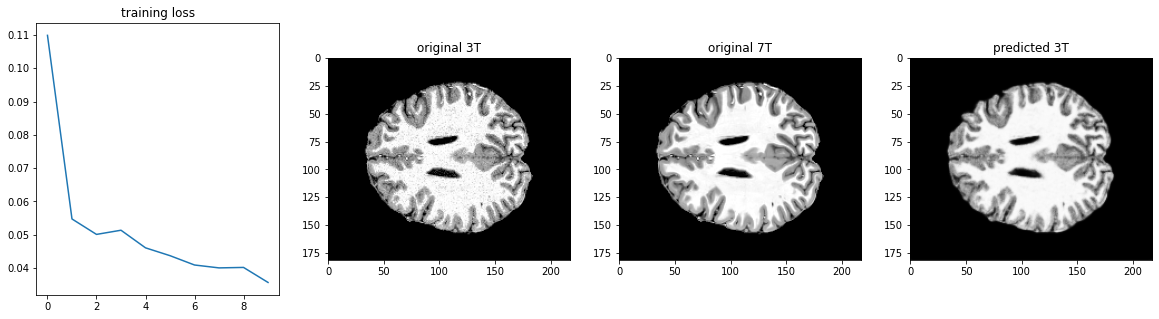

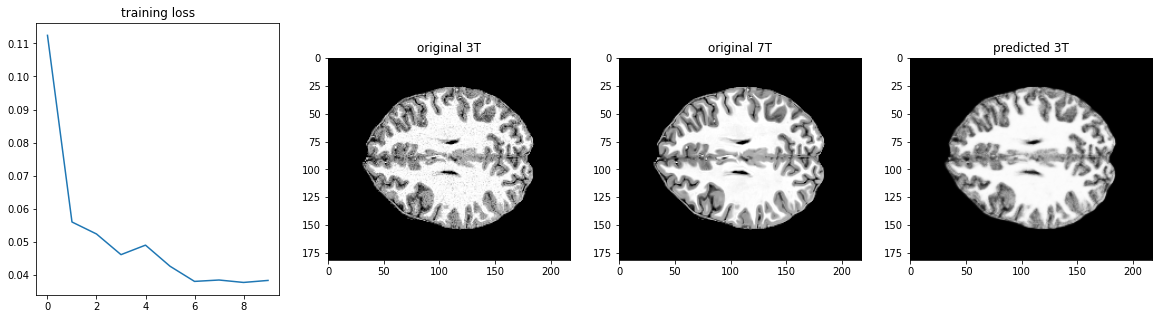

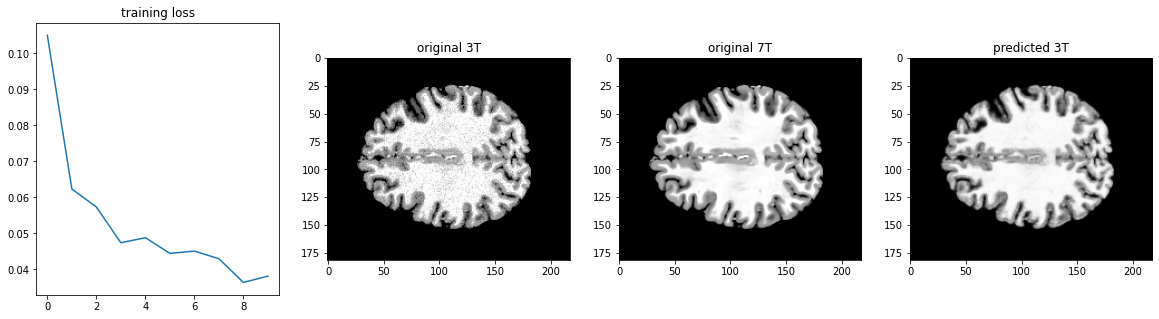

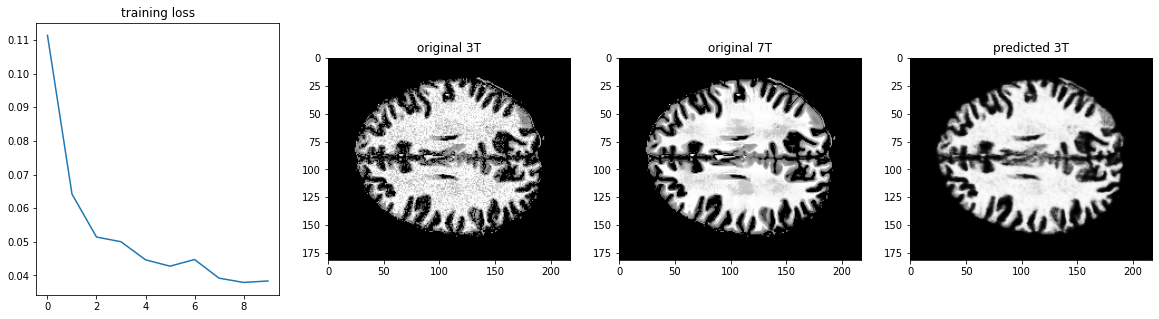

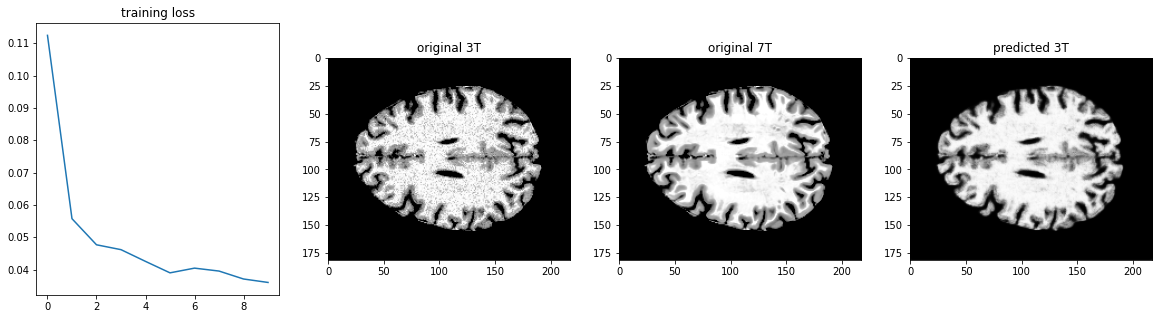

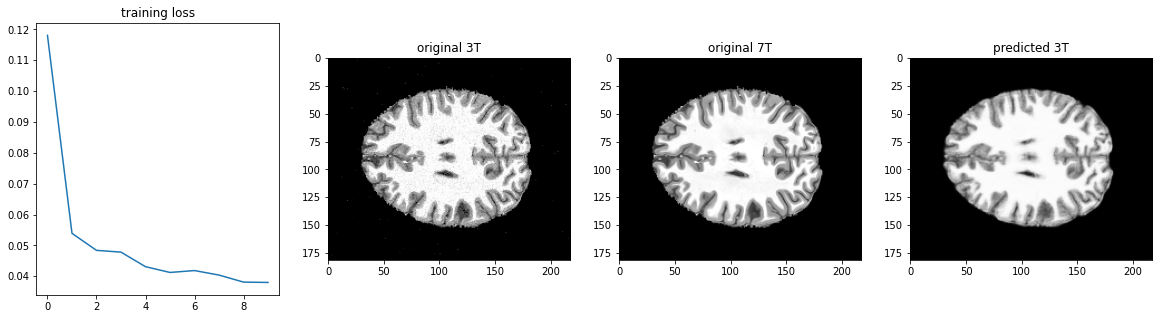

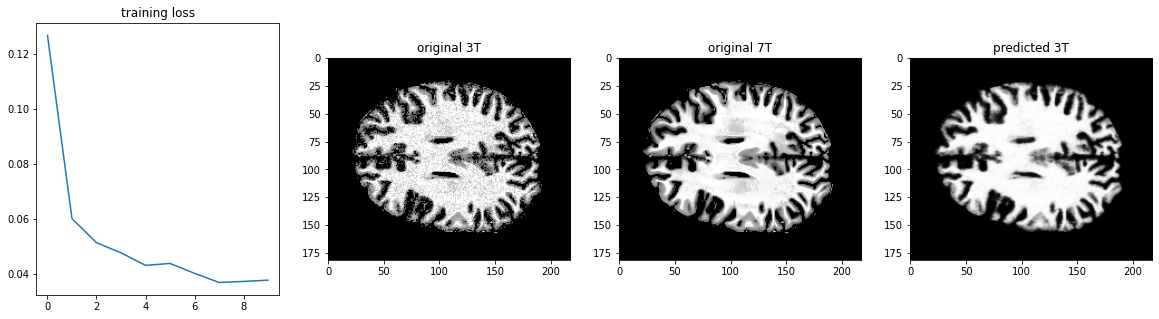

In [ ]:
# initialize tqdm callback with default parameters
EPOCHS = 10
ssim_list = []
psnr_list = []
mae_list = []

list_synth_7T = []

for i in range(10):
  model = final_model()
  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=optim_schedules)
  model.compile(optimizer=optimizer,
              loss='mae', 
              run_eagerly=True)
  
  dataset = training_dataset(i)
  filename = list_3T[i]

  img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
  img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()
  img_3T_test = tf.convert_to_tensor(img_3T, dtype=tf.float32)
  img_7T_test = tf.convert_to_tensor(img_7T, dtype=tf.float32)

  # training the model
  history = model.fit(dataset, 
            epochs=EPOCHS)
  synth_7T = inference(img_3T_test, model, nb_exc_slices=30)
  list_synth_7T.append(synth_7T)

  fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
  axes[0].plot(history.history['loss'])
  axes[1].imshow(img_3T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[2].imshow(img_7T_test[:, :, 100], cmap='gray', vmin=0, vmax=1)
  axes[3].imshow(synth_7T[:, :, 100], cmap='gray', vmin=0, vmax=1)

  axes[0].set(title='training loss')
  axes[1].set(title='original 3T')
  axes[2].set(title='original 7T')
  axes[3].set(title='predicted 3T')

  mae = tf.reduce_mean(tf.abs(synth_7T - img_7T_test)).numpy()
  psnr = tf.image.psnr(img_7T_test, synth_7T, max_val=1.0).numpy()
  ssim = tf.image.ssim(img_7T_test, synth_7T, max_val=1.0).numpy()
  ssim_list.append(ssim)
  psnr_list.append(psnr)
  mae_list.append(mae)

  print(f'SSIM: {round(ssim, 3)} | PNSR: {round(psnr, 3)} | MAE: {round(mae, 3)}')
  

__Display performance metrics__

In [ ]:
print(f'Mean SSIM: {np.mean(ssim_list)}\t|\t Std SSIM: {np.std(ssim_list)}')
print(f'Mean MAE: {np.mean(mae_list)}\t|\t Std MAE: {np.std(mae_list)}')
print(f'Mean PSNR: {np.mean(psnr_list)}\t|\t Std PSNR: {np.std(psnr_list)}')

Mean SSIM: 0.952666163444519	|	 Std SSIM: 0.016317225992679596
Mean MAE: 0.013583133928477764	|	 Std MAE: 0.004005071707069874
Mean PSNR: 28.028289794921875	|	 Std PSNR: 2.0202949047088623


__Save synthetised images__

In [ ]:
# save synthetised images 
f_7T_synth_cnn_basic = '/content/drive/MyDrive/G4/MLSP/project/synth_7T_cnn_basic/'
for i, filename in enumerate(list_3T):
  np.savez(os.path.join(f_7T_synth_cnn_basic, filename+'.npz'), x = list_synth_7T[i])

__Compute worst case metrics: compare originat 7T and 3T__

In [ ]:
# compute worst case metrics: metrics to compare originat 7T and 3T

worst_mae = []
worst_ssim = []
worst_psnr = []

for i in range(10):
  filename = list_3T[i]

  img_3T = nib.load(os.path.join(f_3T_name, filename)).get_fdata()
  img_7T = nib.load(os.path.join(f_7T_name, filename)).get_fdata()
  img_3T_test = tf.convert_to_tensor(img_3T, dtype=tf.float32)
  img_7T_test = tf.convert_to_tensor(img_7T, dtype=tf.float32)

  mae = tf.reduce_mean(tf.abs(img_7T_test - img_3T_test)).numpy()
  psnr = tf.image.psnr(img_7T_test, img_3T_test, max_val=1.0).numpy()
  ssim = tf.image.ssim(img_7T_test, img_3T_test, max_val=1.0).numpy()
  worst_ssim.append(ssim)
  worst_psnr.append(psnr)
  worst_mae.append(mae)


In [ ]:
print(f'Mean SSIM: {np.mean(worst_ssim)}\t|\t Std SSIM: {np.std(worst_ssim)}')
print(f'Mean MAE: {np.mean(worst_mae)}\t|\t Std MAE: {np.std(worst_mae)}')
print(f'Mean PSNR: {np.mean(worst_psnr)}\t|\t Std PSNR: {np.std(worst_psnr)}')

Mean SSIM: 0.9490196108818054	|	 Std SSIM: 0.01727711223065853
Mean MAE: 0.012005136348307133	|	 Std MAE: 0.004079838749021292
Mean PSNR: 28.7585506439209	|	 Std PSNR: 2.886545181274414
